<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/ViT_Module_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ViTs Variations

src1: https://colab.research.google.com/github/hirotomusiker/schwert_colab_data_storage/blob/master/notebook/Vision_Transformer_Tutorial.ipynb<br>

src2: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial15/Vision_Transformer.html

In [1]:
!pip -q install timm pandas requests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.4 MB/s eta 0:00:00


device =  cpu


--2023-08-01 11:20:56--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 74.125.137.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2023-08-01 11:20:58 (68.6 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]

--2023-08-01 11:20:58--  https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/hirotomusiker/schwert_colab_data_storage/raw/master/images/vit_dem

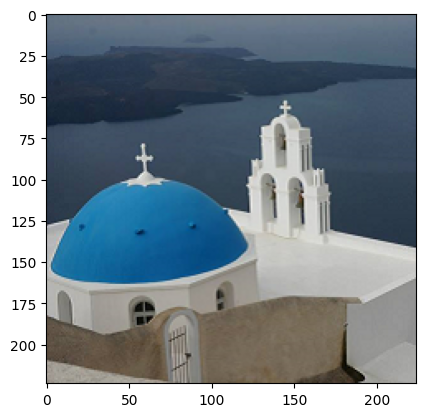

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model

model_name = "vit_base_patch16_224"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
# create a ViT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
model = create_model(model_name, pretrained=True).to(device)

# Define transforms for test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

# capture
# ImageNet Labels
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

# Demo Image
!wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

# end-to-end inference
output = model(img_tensor)

print("Inference Result:")
print(imagenet_labels[int(torch.argmax(output))])
plt.imshow(img)

# Dig into Vision Transformer

<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/vit_input.png?raw=true'>

Figure 1. Vision Transformer inference pipeline.  
1. Split Image into Patches  
The input image is split into 14 x 14 vectors with dimension of 768 by Conv2d (k=16x16) with stride=(16, 16).
2. Add Position Embeddings  
Learnable position embedding vectors are added to the patch embedding vectors and fed to the transformer encoder.
3. Transformer Encoder  
The embedding vectors are encoded by the transformer encoder. The dimension of input and output vectors are the same. Details of the encoder are depicted in Fig. 2.
4. MLP (Classification) Head  
The 0th output from the encoder is fed to the MLP head for classification to output the final classification results.

1. Split Image into Patches

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 196, 768])


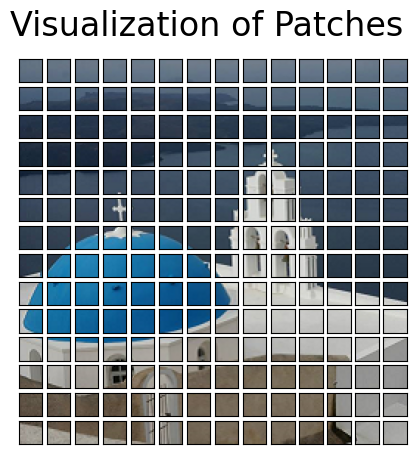

In [12]:
patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)

# This is NOT a part of the pipeline.
# Actually the image is divided into patch embeddings by Conv2d
# with stride=(16, 16) shown above.
fig = plt.figure(figsize=(5, 5))
fig.suptitle("Visualization of Patches", fontsize=24)
rect = 0.15, 0.1, 0.4, 0.1 #left, bottom, width, height)
fig.add_axes(rect)
plt.axis('off')
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

2. Add Position Embeddings

torch.Size([1, 197, 768])


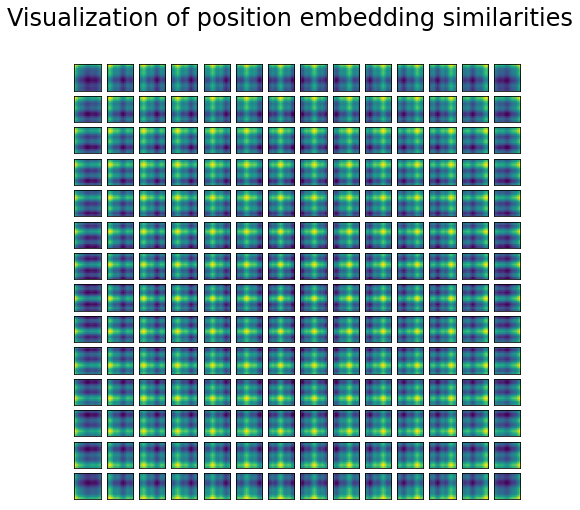

In [ ]:
pos_embed = model.pos_embed
print(pos_embed.shape)

# Visualize position embedding similarities.
# One cell shows cos similarity between an embedding and all the other embeddings.
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

Make Transformer Input:<br>
A learnable class token is prepended to the patch embedding vectors as the 0th vector.
197 (1 + 14 x 14) learnable position embedding vectors are added to the patch embedding vectors.

In [ ]:
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

Transformer input:  torch.Size([1, 197, 768])


# 3. Transformer Encoder
<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/transformer_encoder.png?raw=true'>

Figure 2. Detailed schematic of Transformer Encoder.
- N (=197) embedded vectors are fed to the L (=12) series encoders.
- The vectors are divided into query, key and value after expanded by an fc layer.
- q, k and v are further divided into H (=12) and fed to the parallel attention heads.
- Outputs from attention heads are concatenated to form the vectors whose shape is the same as the encoder input.
- The vectors go through an fc, a layer norm and an MLP block that has two fc layers.

The Vision Transformer employs the Transformer Encoder that was proposed in the [attention is all you need paper](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).

Implementation Reference:

- [tensorflow implementation](https://github.com/google-research/vision_transformer/blob/502746cb287a107f9911c061f9d9c2c0159c81cc/vit_jax/models.py#L62-L146)
- [pytorch implementation (timm)](https://github.com/rwightman/pytorch-image-models/blob/198f6ea0f3dae13f041f3ea5880dd79089b60d61/timm/models/vision_transformer.py#L79-L143)

In [ ]:
#Series Transformer Encoders
print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}, input:{}".format(i, x.shape))
    x = blk(x)
x = model.norm(x)
transformer_output = x[:, 0]
print("Output vector from Transformer (z12-0):", transformer_output.shape)

Input tensor to Transformer (z0):  torch.Size([1, 197, 768])
Entering the Transformer Encoder 0, input:torch.Size([1, 197, 768])
Entering the Transformer Encoder 1, input:torch.Size([1, 197, 768])
Entering the Transformer Encoder 2, input:torch.Size([1, 197, 768])
Entering the Transformer Encoder 3, input:torch.Size([1, 197, 768])
Entering the Transformer Encoder 4, input:torch.Size([1, 197, 768])
Entering the Transformer Encoder 5, input:torch.Size([1, 197, 768])
Entering the Transformer Encoder 6, input:torch.Size([1, 197, 768])
Entering the Transformer Encoder 7, input:torch.Size([1, 197, 768])
Entering the Transformer Encoder 8, input:torch.Size([1, 197, 768])
Entering the Transformer Encoder 9, input:torch.Size([1, 197, 768])
Entering the Transformer Encoder 10, input:torch.Size([1, 197, 768])
Entering the Transformer Encoder 11, input:torch.Size([1, 197, 768])
Output vector from Transformer (z12-0): torch.Size([1, 768])


How Attention Works

Transformer Multi-head Attention block:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
input of the transformer encoder: torch.Size([1, 197, 768])
expanded to:  torch.Size([197, 2304])
split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])
attention matrix:  torch.Size([12, 197, 197])


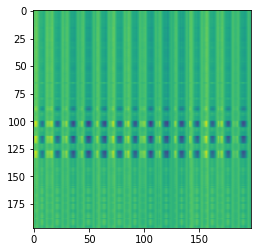

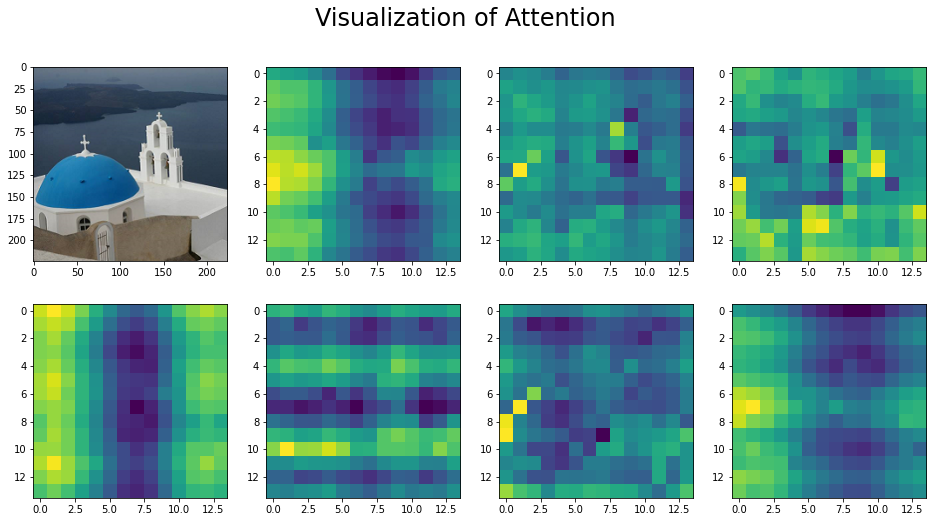

In [ ]:
print("Transformer Multi-head Attention block:")
attention = model.blocks[0].attn
print(attention)
print("input of the transformer encoder:", transformer_input.shape)

# fc layer to expand the dimension
transformer_input_expanded = attention.qkv(transformer_input)[0]
print("expanded to: ", transformer_input_expanded.shape)

# Split qkv into mulitple q, k, and v vectors for multi-head attantion
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("transposed ks: ", kT.shape)

# Attention Matrix
attention_matrix = q @ kT
print("attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention", fontsize=24)
fig.add_axes()
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

# 4. MLP (Classification) Head

Classification head:  Linear(in_features=768, out_features=1000, bias=True)
Inference result : id = 538, label name = dome



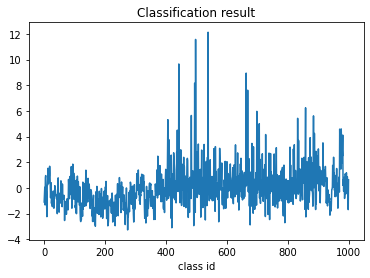

In [ ]:
print("Classification head: ", model.head)
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Classification result")
plt.xlabel("class id")
print("Inference result : id = {}, label name = {}".format(
    result_label_id, imagenet_labels[result_label_id]))

# ViTs from https://github.com/jeonsworld/ViT-pytorch

In [ ]:
! git clone https://github.com/jeonsworld/ViT-pytorch
%cd ViT-pytorch

Cloning into 'ViT-pytorch'...
remote: Enumerating objects: 170, done.
remote: Total 170 (delta 0), reused 0 (delta 0), pack-reused 170
Receiving objects: 100% (170/170), 21.20 MiB | 21.02 MiB/s, done.
Resolving deltas: 100% (83/83), done.
/content/ViT-pytorch


In [ ]:
!pip -q install ml_collections

     |████████████████████████████████| 77 kB 4.0 MB/s 


torch.Size([3, 224, 224])
mean att_mat + residual_att + sum + Multi: torch.Size([197, 197])
grid_size: 14 torch.Size([196])
(480, 720, 1) (480, 720, 3) 0.99895155 255
Prediction Label and Attention Map!

0.91622 : Pembroke, Pembroke_Welsh_corgi
0.08092 : Cardigan, Cardigan_Welsh_corgi
0.00029 : Shetland_sheepdog, Shetland_sheep_dog, Shetland
0.00027 : basenji
0.00015 : papillon


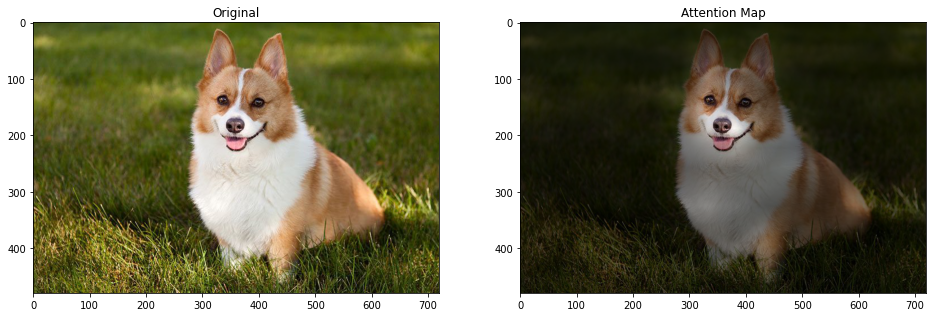

In [ ]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from PIL import Image
from torchvision import transforms
from models.modeling import VisionTransformer, CONFIGS

os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))


# Test Image
#img_url = 'https://www.purina.co.uk/sites/default/files/styles/square_medium_440x440/public/2022-08/Welsh-Corgi-Pembroke.jpg'
img_url = 'https://www.animalfunfacts.net/images/stories/pets/dogs/pembroke_welsh_corgi_l.jpg'
urlretrieve(img_url, "attention_data/img.jpg")

# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
im = Image.open("attention_data/img.jpg")
x = transform(im)
print(x.size())

logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)
# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)
# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

# Attention from the output token to the input space.
v = joint_attentions[-1]
print('mean att_mat + residual_att + sum + Multi:',v.shape)
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
print('grid_size:', grid_size, v[0, 1:].shape)
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
print(mask.shape, np.array(im).shape, mask.max(), np.array(im).max())
result = (mask * im).astype("uint8")

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

In [ ]:
model

VisionTransformer(
  (transformer): Transformer(
    (embeddings): Embeddings(
      (patch_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): Encoder(
      (layer): ModuleList(
        (0): Block(
          (attention_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (ffn): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (attn): Attention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (out): Linear(in_features=768, out_features=768, bias=True)
     

# Classifying Images with DeiT

In [ ]:
from PIL import Image
import torch
import timm
import requests
import torchvision.transforms as transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

print(torch.__version__)
# should be 1.8.0


model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model.eval()

transform = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

img = Image.open(requests.get("https://raw.githubusercontent.com/pytorch/ios-demo-app/master/HelloWorld/HelloWorld/HelloWorld/image.png", stream=True).raw)
img = transform(img)[None,]
out = model(img)
clsidx = torch.argmax(out)
print(clsidx.item())

1.12.1+cu113


Downloading: "https://github.com/facebookresearch/deit/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_base_patch16_224-b5f2ef4d.pth" to /root/.cache/torch/hub/checkpoints/deit_base_patch16_224-b5f2ef4d.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


269


Save Weights as TorchScript format:

In [ ]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model.eval()
scripted_model = torch.jit.script(model)
scripted_model.save("fbdeit_scripted.pt")

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main
